In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import eli5
import sklearn

from eli5.sklearn import PermutationImportance
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report
from scipy.stats import uniform, randint

# EDA

In [2]:
train = pd.read_csv('data/train.csv', index_col = 0)
test = pd.read_csv('data/test.csv', index_col = 0)

train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [4]:
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


## 데이터 전처리
1. 성별, 차 소유 여부, 부동산 소유 여부를 이진분류로 0(미소유)과 1(소유)로 변환
2. DAYS_BIRTH를 사용하여 사용자의 나이 계산하여 AGE 칼럼 생성
3. DAYS_EMPLOYED를 사용하여 사용자의 직장 연차 계산하여 WORK_YEAR 칼럼 생성
4. begin_month 사용하여 사용자의 신용카드 이용 개월 수 계산하여 use_month 칼럼 생성
5. occyp_type 결측치 중 work_year이 0 인 사용자들은 Unoccupied로 그 외 결측치는 Laborers로 채워줬다.

In [5]:
def preprocessing(df):
    df['gender'] = df['gender'].map(lambda x: 1 if x == 'M' else 0)
    df['car'] = df['car'].map(lambda x: 1 if x == 'Y' else 0)
    df['reality'] = df['reality'].map(lambda x: 1 if x == 'Y' else 0)

    df['age'] = (df['DAYS_BIRTH'].abs())/365
    df['age'] = df['age'].astype(int)

    df['work_year'] = (-df['DAYS_EMPLOYED'])/365
    df.loc[df['work_year'] < 0, 'work_year'] = 0
    df['work_year'] = df['work_year'].apply(np.ceil).astype(int)

    df['use_month'] = df['begin_month'].abs()
    df['use_month'] = df['use_month'].astype(int)

    df['family_size'] = df['family_size'].astype(int)

    df.loc[df['work_year'] == 0, 'occyp_type'] = 'Unoccupied'
    df['occyp_type'] = df['occyp_type'].fillna('Laborers')

    return df

## 이상치 제거
데이터 분석 중 
1. 같은 사용자가 복수의 신용카드를 가지고 있을 경우 한 사용자에 대한 데이터가 각 신용카드 별로 기입 되있음을 확인.
2. 만약 같은 사용자를 ID화 시켜서 ID칼럼을 만들어 분석 할 경우 더 정확한 예측이 가능할 것이다.
3. 그러나 그렇게되면 이전의 다른 데이터를 가지고 오는 것이라 판단되어 문제의 논점이 흐려지는 것 같다.

In [6]:
def outlier(df):
    df = df[(df['family_size'] <= 7)]
    return df

In [7]:
train_copy = train.copy()
test_copy = test.copy()

train_proccessed = outlier(preprocessing(train_copy))
test_proccessed = preprocessing(test_copy)

## Divide Feature/Target Data

In [8]:
feature = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'family_size', 'age', 'work_year', 'use_month', 'income_total']
target = ['credit']

X_train = train_proccessed[feature]
y_train = train_proccessed[target]
train = pd.concat([X_train, y_train], axis = 1)

X_test = test_proccessed[feature]

## Analysis on Target

In [9]:
def analysis_on_target(df):
    """
    n_zero_label, n_one_label에
    각각 label이 0인 데이터의 수, label이 1인 데이터의 수를 담아 반환하세요.
    """
    n_zero_label, n_one_label, n_two_label = -1, -1, -1

    n_two_label = sum(df['credit'] == 2)
    n_one_label = sum(df['credit'] == 1)
    n_zero_label = sum(df['credit'] == 0)

    plt.pie(
        (n_zero_label, n_one_label, n_two_label),
        labels=(0, 1, 2),
        autopct="%.2f%%",
        shadow=True,
        startangle=90,
    )
    plt.title("Target: Inspection Fail", size=15)
    plt.show()

    return n_zero_label, n_one_label, n_two_label

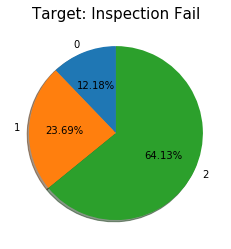

(3222, 6267, 16962)

In [10]:
analysis_on_target(y_train)

## Visualization

### Credit Level Distribution by Income Type

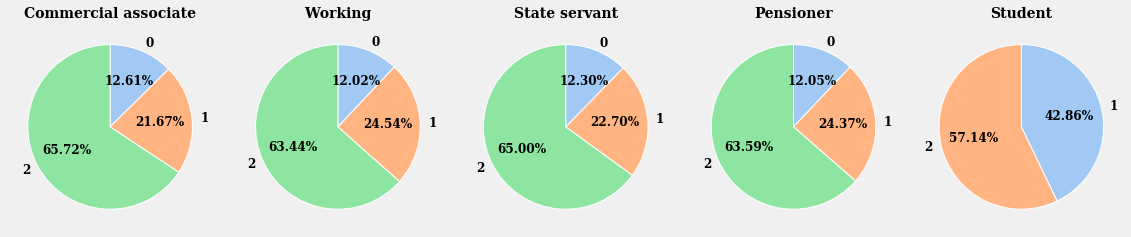

In [11]:
fig, ax = plt.subplots(figsize=(16,8),facecolor='#F0F0F0')
sns.set_theme(style='whitegrid', palette="pastel")
explode = [0.1, 0, 0]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 3}
font = {'family': 'serif',
         'color': 'black',
         'weight': 'bold',
         'size': 14}
font_pie = {'family': 'serif',
            'weight' : 'bold',
            'color': 'black',
            'size': 12}
            
income_type = train['income_type'].unique()

for i, type in enumerate(income_type):
        df = train[train['income_type'] == type].groupby('credit').count()['gender']
        plt.subplot(1,5,i + 1)
        plt.pie(df, labels = df.index.astype(int), 
                # explode= explode, wedgeprops=wedgeprops, 
                autopct='%.2f%%', counterclock=False, startangle = 90,
                textprops=font_pie)
        plt.title(type, fontdict = font)


fig.tight_layout()
plt.savefig('Graph/income type pie graph', dpi = 200)
plt.show()

### Average Credit Level by Family Size

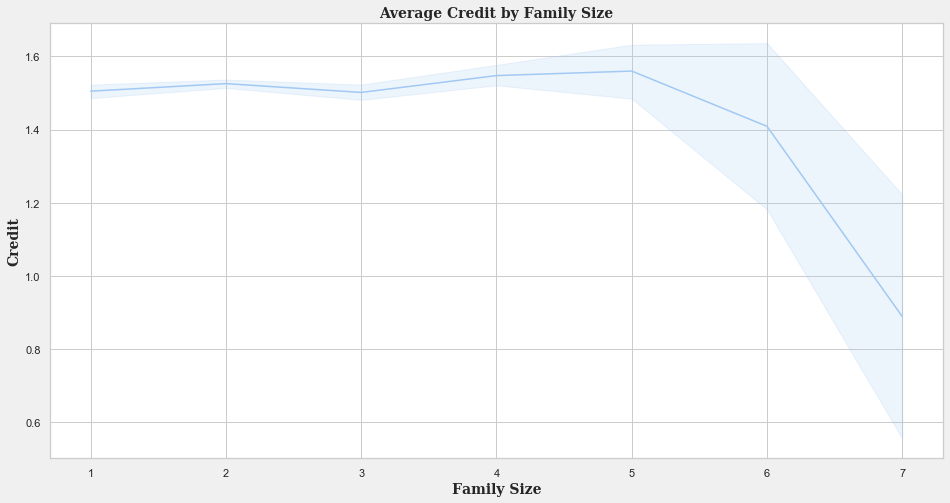

In [12]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor='#F0F0F0')
sns.set_theme(style='whitegrid', palette="pastel")
font = {'family': 'serif',
         'weight': 'bold',
         'size': 14}

df = train.groupby('family_size').mean()['credit']

sns.lineplot(x = train['family_size'], y = train['credit'], markers=False)
plt.title('Average Credit by Family Size', fontdict= font)
plt.ylabel('Credit', fontdict=font)
plt.xlabel('Family Size', fontdict=font)
plt.savefig('Graph/Average Credit by Family Size', dpi = 200)

plt.show()

### Average Credit Level by Work Year

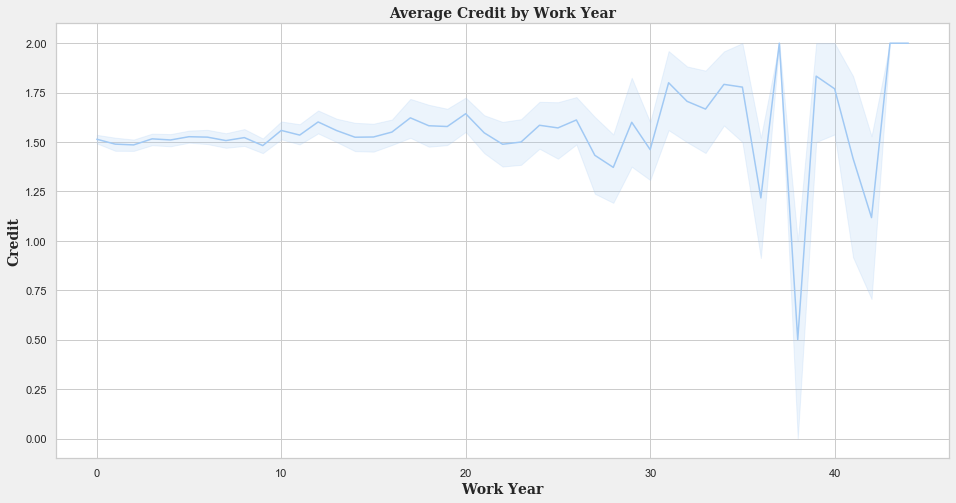

In [13]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor='#F0F0F0')
sns.set_theme(style='whitegrid', palette="pastel")
font = {'family': 'serif',
         'weight': 'bold',
         'size': 14}

df = train.groupby('work_year').mean()['credit']

sns.lineplot(x = train['work_year'], y = train['credit'], markers=False)
plt.title('Average Credit by Work Year', fontdict= font)
plt.ylabel('Credit', fontdict=font)
plt.xlabel('Work Year', fontdict=font)
plt.savefig('Graph/Average Credit by Work Year', dpi = 200)

plt.show()

### Average Credit Level by Months Used

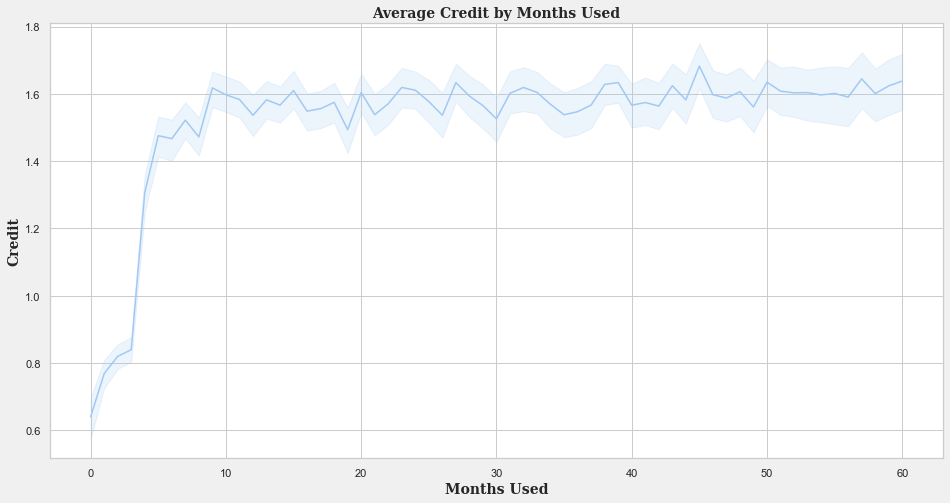

In [14]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor='#F0F0F0')
sns.set_theme(style='whitegrid', palette="pastel")
font = {'family': 'serif',
         'weight': 'bold',
         'size': 14}

sns.lineplot(x = train['use_month'], y = train['credit'], markers=False)
plt.title('Average Credit by Months Used', fontdict= font)
plt.ylabel('Credit', fontdict=font)
plt.xlabel('Months Used', fontdict=font)
plt.savefig('Graph/Average Credit by Months Used', dpi = 200)

plt.show()

## Save Data

In [15]:
train.to_csv('data/train_clean.csv')
X_test.to_csv('data/test_clean.csv')

# Modeling

In [16]:
train = pd.read_csv('data/train_clean.csv', index_col = 0)
X_test = pd.read_csv('data/test_clean.csv', index_col = 0)
submission = pd.read_csv('data/sample_submission.csv')

target = ['credit']
feature_n  = train.columns.drop(target)

X_train = train[feature]
y_train = train[target]

### Baseline Model

In [17]:
total = len(y_train)
zero = float((y_train == 0).sum() / total)
one = float((y_train == 1).sum() / total)
two = float((y_train == 2).sum() / total)

baseline = [zero, one, two]
baseline_proba = [baseline] * total
baseline_pred = [2] * total

In [18]:
print('Baseline Model')
print('Accuracy : ', accuracy_score(y_train, baseline_pred))
print('Log Loss : ', log_loss(y_train, baseline_proba))
print(classification_report(y_train, baseline_pred))

Baseline Model
Accuracy :  0.641261199954633
Log Loss :  0.8825464036975457
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3222
         1.0       0.00      0.00      0.00      6267
         2.0       0.64      1.00      0.78     16962

    accuracy                           0.64     26451
   macro avg       0.21      0.33      0.26     26451
weighted avg       0.41      0.64      0.50     26451



/Users/mhson/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhson/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhson/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Scoring

In [19]:
def model_score(pipe):
    train_acc = pipe.score(X_train, y_train)
    y_train_proba = pipe.predict_proba(X_train)
    train_logloss = log_loss(y_train, y_train_proba)

    print('Model Score')
    print('Train Set Accuracy Score : ', train_acc)
    print('Train Set Log Loss Score : ', train_logloss)

### DecisionTreeClassifier

In [36]:
dtc_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', DecisionTreeClassifier(random_state=42))], verbose = 1)

dtc_model.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['income_type',
                                                       'edu_type',
                                                       'family_type',
                                                       'house_type',
                                                       'occyp_type'],
                                                 mapping=[{'col': 'income_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Commercial associate    1
Working                 2
State servant           3
Pensioner               4
Student                 5
NaN                    -2
dtype: int64},
                                                          {'col': 'edu_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Highe...
High skill tech staff     4
Core staff                5
Drivers                   6
Medicine staff            7
Accountants               8
Unoccupied                9
Realty agents            10
Security staff           11
Cleaning staff           12
Private service staff    13
Cooking staff            14
Secretaries              15
HR staff                 16
IT staff                 17
Low-skill Laborers       18
Waiters/barmen staff     19
NaN                      -2
dtype: int64}])),
                                 ('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))],
         verbose=1)

In [37]:
model_score(dtc_model)

Model Score
Train Set Accuracy Score :  0.9720237420135345
Train Set Log Loss Score :  0.04080323143285966


### RandomForestClassifier

In [39]:
rfc_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))], verbose = 1)

rfc_model.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   2.2s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['income_type',
                                                       'edu_type',
                                                       'family_type',
                                                       'house_type',
                                                       'occyp_type'],
                                                 mapping=[{'col': 'income_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Commercial associate    1
Working                 2
State servant           3
Pensioner               4
Student                 5
NaN                    -2
dtype: int64},
                                                          {'col': 'edu_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Highe...
Medicine staff            7
Accountants               8
Unoccupied                9
Realty agents            10
Security staff           11
Cleaning staff           12
Private service staff    13
Cooking staff            14
Secretaries              15
HR staff                 16
IT staff                 17
Low-skill Laborers       18
Waiters/barmen staff     19
NaN                      -2
dtype: int64}])),
                                 ('simpleimputer',
                                  SimpleImputer(strategy='median'))])),
                ('classifier',
                 RandomForestClassifier(n_estimators=500, n_jobs=-1,
                                        random_state=42))],
         verbose=1)

In [40]:
model_score(rfc_model)

Model Score
Train Set Accuracy Score :  0.9720237420135345
Train Set Log Loss Score :  0.18423396165660552


### XGB Classifier

In [ ]:
xgb_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', XGBClassifier(n_estimators=500, random_state=42, n_jobs=-1))], verbose = 1)
    
xgb_model.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   6.9s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['income_type',
                                                       'edu_type',
                                                       'family_type',
                                                       'house_type',
                                                       'occyp_type'],
                                                 mapping=[{'col': 'income_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Commercial associate    1
Working                 2
State servant           3
Pensioner               4
Student                 5
NaN                    -2
dtype: int64},
                                                          {'col': 'edu_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Highe...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.2, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=7, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))],
         verbose=1)

In [42]:
model_score(xgb_model)
print(classification_report(xgb_model.predict(X_train), y_train))

Model Score
Train Set Accuracy Score :  0.8019356546066311
Train Set Log Loss Score :  0.49105023397055647
              precision    recall  f1-score   support

           0       0.35      0.94      0.51      1207
           1       0.53      0.91      0.67      3615
           2       0.99      0.78      0.87     21629

    accuracy                           0.80     26451
   macro avg       0.62      0.87      0.68     26451
weighted avg       0.90      0.80      0.83     26451



### Hyperparameter Tunning

#### XGBoost

In [23]:
%%time

params = {
    'classifier__max_depth' : [5,6,7,8,9,10,15], 
    'classifier__min_child_weight' : [5,7,10,15], 
    'classifier__colsample_bytree' : [0.5,0.75],
    'classifier__learning_rate' : uniform(0,0.2)
    }

randcv = RandomizedSearchCV(xgb_model,
                            param_distributions=params,
                            n_iter = 10,
                            cv=5,
                            scoring = 'neg_log_loss',
                            verbose = 100,
                            random_state = 42)
                            
randcv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START classifier__colsample_bytree=0.5, classifier__learning_rate=0.15930859737204658, classifier__max_depth=15, classifier__min_child_weight=10
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   9.6s
[CV 1/5; 1/10] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.15930859737204658, classifier__max_depth=15, classifier__min_child_weight=10;, score=-0.754 total time=   9.7s
[CV 2/5; 1/10] START classifier__colsample_bytree=0.5, classifier__learning_rate=0.15930859737204658, classifier__max_depth=15, classifier__min_child_weight=10
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   8.6s
[CV 2/5; 1/10] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.15930859737204658, classifier__max_depth=15, classifier__min_c

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('ordinalencoder',
                                                               OrdinalEncoder(cols=['income_type',
                                                                                    'edu_type',
                                                                                    'family_type',
                                                                                    'house_type',
                                                                                    'occyp_type'],
                                                                              mapping=[{'col': 'income_type',
                                                                                        'data_type': dtype('O'),
                                                                                        'mapping': Commercial associate    1
Working                 2
State servant           3
Pensioner               4
Student                 5
NaN                    -2
dtype: int64},
                                                                                       {'col': 'edu_type',
                                                                                        'dat...
                                                            predictor='auto',
                                                            random_state=42,
                                                            reg_alpha=0, ...))],
                                      verbose=1),
                   param_distributions={'classifier__colsample_bytree': [0.5,
                                                                         0.75],
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13f6f1670>,
                                        'classifier__max_depth': [5, 6, 7, 8, 9,
                                                                  10, 15],
                                        'classifier__min_child_weight': [5, 7,
                                                                         10,
                                                                         15]},
                   random_state=42, scoring='neg_log_loss', verbose=100)

In [24]:
randcv.best_params_

{'classifier__colsample_bytree': 0.5,
 'classifier__learning_rate': 0.06084844859190755,
 'classifier__max_depth': 10,
 'classifier__min_child_weight': 5}

In [25]:
xgb_tuned = randcv.best_estimator_
xgb_tuned.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   7.0s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['income_type',
                                                       'edu_type',
                                                       'family_type',
                                                       'house_type',
                                                       'occyp_type'],
                                                 mapping=[{'col': 'income_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Commercial associate    1
Working                 2
State servant           3
Pensioner               4
Student                 5
NaN                    -2
dtype: int64},
                                                          {'col': 'edu_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Highe...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.06084844859190755, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0, min_child_weight=5,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))],
         verbose=1)

In [26]:
model_score(xgb_tuned)

Model Score
Train Set Accuracy Score :  0.7493856564969188
Train Set Log Loss Score :  0.591477421575608


#### Decision Tree Classifier

In [ ]:
%%time

params = {
    'classifier__max_depth' : [5,6,7,8,9,10,15], 
    'classifier__min_child_weight' : [5,7,10,15]
    }

randcv = RandomizedSearchCV(dtc_model,
                            param_distributions=params,
                            n_iter = 10,
                            cv=5,
                            scoring = 'neg_log_loss',
                            verbose = 100,
                            random_state = 42)
                            
randcv.fit(X_train, y_train)

In [ ]:
randcv.best_params_

In [ ]:
dtc_tuned = randcv.best_estimator_
dtc_tuned.fit(X_train, y_train)

In [ ]:
model_score(dtc_tuned)

### Feature Importance

In [27]:
permuter = PermutationImportance(
    xgb_tuned.named_steps['classifier'],
    scoring = 'neg_log_loss',
    n_iter = 5,
    random_state = 42
)

X_train_transformed = xgb_tuned.named_steps['preprocessing'].transform(X_train)
permuter.fit(X_train_transformed, y_train)

eli5.show_weights(
permuter, 
top=None, # top n 지정 가능, None 일 경우 모든 특성 
feature_names= list(X_train.columns) # list 형식으로 넣어야 합니다
)

Weight,Feature
0.2552 ± 0.0046,use_month
0.1107 ± 0.0014,age
0.0800 ± 0.0008,income_total
0.0741 ± 0.0012,work_year
0.0565 ± 0.0018,occyp_type
0.0346 ± 0.0004,family_type
0.0302 ± 0.0009,income_type
0.0290 ± 0.0005,family_size
0.0269 ± 0.0010,edu_type
0.0198 ± 0.0008,reality


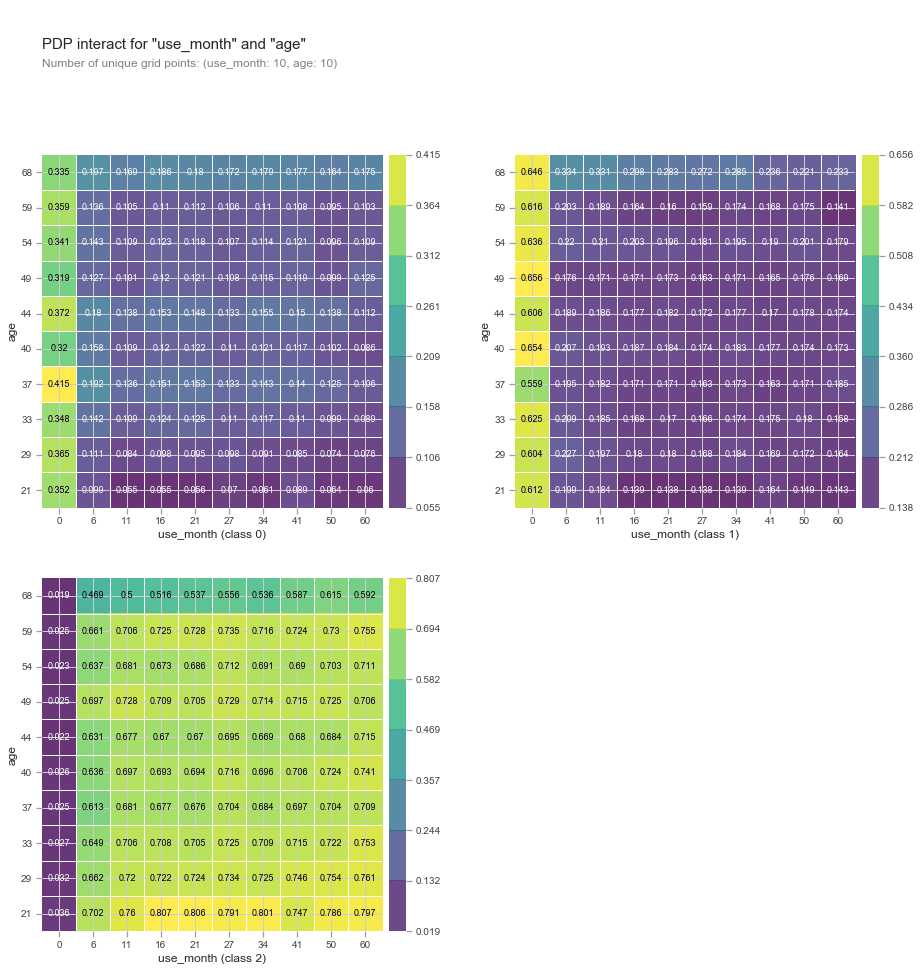

In [28]:
from pdpbox.pdp import pdp_isolate, pdp_plot,pdp_interact, pdp_interact_plot
feature = ['use_month', 'age']

isolated = pdp_interact(
    model=xgb_tuned, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=feature,
)

pdp_interact_plot(isolated, plot_type='grid', feature_names=feature);

# Submission

In [29]:
def submit(pipe, num):
    y_test_proba = pipe.predict_proba(X_test)
    submission.iloc[:, 1:] = y_test_proba
    submission.to_csv('data/submission' + str(num) + '.csv', index = False)

In [43]:
submit(dtc_model, 4)